<a href="https://colab.research.google.com/github/Riverag0011/ADS509-Text-Mining/blob/main/Assignment_3_Group_Comparison_GR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 Group Comparison

Name: Gabi Rivera \
Course: ADS509-01 \
Date: 22Sep2024

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
file_path = '/content/drive/MyDrive/Colab Notebooks/M1 Results/'

# ADS 509 Module 3: Group Comparison

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following:

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set.
* Calculate descriptive statistics on the two sets of lyrics and compare the results.
* For each of the four corpora, find the words that are unique to that corpus.
* Build word clouds for all four corpora.

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization).


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*


In [3]:
import os
import re
#!pip install emoji
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
#!pip install wordcloud
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [4]:
# Use this space for any additional import statements you need
import nltk
nltk.download('stopwords')
from wordcloud import STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Define punctuation variations
punctuation = set(punctuation)
tw_punct = punctuation - {"#"}

# Stopwords
sw = set(stopwords.words("english"))

# Regular expressions
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Initialize an empty set to hold all emojis
all_language_emojis = set()

# Iterate through the emoji data to gather all emojis
for country in emoji.EMOJI_DATA:
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)

# Functions
def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """ Print and return descriptive statistics for token data. """
    num_tokens_count = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens / num_tokens_count if num_tokens_count > 0 else 0
    num_characters = sum(len(token) for token in tokens)
    most_common_tokens = Counter(tokens).most_common(num_tokens)

    if verbose:
        print(f"There are {num_tokens_count} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        print(f"Most common tokens: {most_common_tokens}")

    return [num_tokens_count, num_unique_tokens, lexical_diversity,
            num_characters]

def contains_emoji(s):
    """ Check if the string contains any emoji. """
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return len(emojis) > 0

def remove_stopstopwords(tokens):
    """ Remove stopwords and filter tokens to include only alphabetic words longer than 2 characters. """
    return [word for word in tokens if word.lower() not in sw and word.isalpha() and len(word) > 2]

def remove_punctuation(text, punct_set=tw_punct):
    """ Remove specified punctuation from the text. """
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    """ Split the text into tokens, preserving hashtags and alphanumeric sequences. """
    tokens = whitespace_pattern.split(text)
    return [token for token in tokens if token]

def prepare(text, pipeline):
    """ Apply a series of transformations to the text. """
    tokens = str(text)

    for transform in pipeline:
        tokens = transform(tokens)

    return tokens


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [6]:
# Feel free to use the below cells as an example or read in the data in a way you prefer

# Define file paths
data_location = file_path
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

# Define artist files
artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [7]:
# Read in Twitter data for each artist: Cher
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [8]:
# Read in Twitter data for each artist: Robyn
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

# Combine the Twitter data
twitter_data = pd.concat([
    twitter_data,twitter_data_2], ignore_index=True)

# Clean up by deleting the temporary variable
del(twitter_data_2)

# Display the first few rows of the combined DataFrame
print("Combined Twitter Data:")
print(twitter_data.head())

Combined Twitter Data:
    screen_name          name                   id        location  \
0        hsmcnp  Country Girl             35152213             NaN   
1    horrormomy          Jeny   742153090850164742           Earth   
2  anju79990584          anju  1496463006451974150             NaN   
3  gallionjenna             J           3366479914             NaN   
4       bcscomm       bcscomm             83915043  Washington, DC   

   followers_count  friends_count  \
0             1302           1014   
1               81            514   
2               13            140   
3              752            556   
4              888           2891   

                                         description artist  
0                                                NaN   cher  
1           𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜   cher  
2          163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡   cher  
3                                                csu   cher  
4  Writer @Washinformer

In [9]:
# Initialize an empty dictionary for lyrics data
lyrics_data = {}

# Function to read lyrics from a specified artist's folder
def read_lyrics(artist):
    artist_folder = os.path.join(data_location, lyrics_folder, artist)
    if not os.path.exists(artist_folder):
        print(f"Artist folder does not exist: {artist_folder}")
        return

    print(f"Reading lyrics for {artist} from {artist_folder}...")

    for filename in os.listdir(artist_folder):
        if filename.endswith('.txt'):
            song_title = filename.replace(f"{artist}_", "").replace('.txt', '')
            file_path = os.path.join(artist_folder, filename)
            # Read the lyrics and ensure the DataFrame is created properly
            try:
                lyrics_data[song_title] = {
                    'artist': artist,
                    'lyrics': pd.read_csv(file_path,
                                          sep="\t",
                                          quoting=3).to_string(index=False)
                }
                print(f"Read lyrics for: {song_title}")
            except Exception as e:
                print(f"Error reading {filename}: {e}")
        else:
            print(f"Skipped non-txt file: {filename}")

# Read lyrics for each artist
read_lyrics('cher')
read_lyrics('robyn')

# Create a DataFrame from the lyrics_data dictionary
# Extract song titles, artists, and lyrics into a DataFrame
lyrics_df = pd.DataFrame([
    (title, data['artist'],
     data['lyrics']) for title, data in lyrics_data.items()
], columns=['title', 'artist', 'lyrics'])

# Check the structure of the DataFrame, print only the first 10 samples
print("Lyrics DataFrame created with the following columns:")
print(lyrics_df.head(10))

Reading lyrics for cher from /content/drive/MyDrive/Colab Notebooks/M1 Results/lyrics/cher...
Read lyrics for: allireallywanttodo
Read lyrics for: igotosleep
Read lyrics for: needlesandpins
Read lyrics for: dontthinktwice
Read lyrics for: dreambaby
Read lyrics for: thebellsofrhymney
Read lyrics for: girldontcome
Read lyrics for: comeandstaywithme
Read lyrics for: crymyselftosleep
Read lyrics for: blowininthewind
Read lyrics for: bangbangmybabyshotmedown
Read lyrics for: ayounggirluneenfante
Read lyrics for: wheredoyougo
Read lyrics for: ourdaywillcome
Read lyrics for: elusivebutterfly
Read lyrics for: likearollingstone
Read lyrics for: olmanriver
Read lyrics for: cometoyourwindow
Read lyrics for: thegirlfromipanema
Read lyrics for: itsnotunusual
Read lyrics for: time
Read lyrics for: milord
Read lyrics for: sunny
Read lyrics for: thetwelfthofnever
Read lyrics for: youdonthavetosayyouloveme
Read lyrics for: ifeelsomethingintheairmagicintheair
Read lyrics for: willyoulovemetomorrow
Read 

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning.

**Lyrics**

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions**

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those.

In [10]:
# Functions
def remove_song_title(lyrics, title):
    """ Remove the song title from the lyrics. """
    return lyrics.replace(title, '')

def remove_punctuation(text):
    """ Remove specified punctuation from the text. """
    return "".join([ch for ch in text if ch not in punctuation])

def tokenize(text):
    """ Split the text into tokens on whitespace. """
    return text.split()

def remove_stopwords(tokens):
    """ Remove stopwords from the tokens. """
    return [word for word in tokens if word.lower() not in sw and len(word) > 2]

def prepare(lyrics, title, remove_sw=False):
    """ Prepare lyrics by cleaning and tokenizing. """
    # Remove the song title
    lyrics_cleaned = remove_song_title(lyrics, title)

    # Casefold to lowercase
    lyrics_cleaned = lyrics_cleaned.lower()

    # Remove punctuation
    lyrics_cleaned = remove_punctuation(lyrics_cleaned)

    # Tokenize
    tokens = tokenize(lyrics_cleaned)

    # Optionally remove stopwords
    if remove_sw:
        tokens = remove_stopwords(tokens)

    return tokens

# Set the option for removing stopwords
remove_stopwords_option = True

# Apply the processing to each song using both lyrics and title
lyrics_df["tokens"] = lyrics_df.apply(
    lambda row: prepare(row['lyrics'], row['title'],
                        remove_stopwords_option), axis=1
)
lyrics_df["num_tokens"] = lyrics_df["tokens"].map(len)

# Display the processed DataFrame
print("Processed Lyrics Data:")
print(lyrics_df[['title', 'artist', 'tokens', 'num_tokens']])

Processed Lyrics Data:
                  title artist  \
0    allireallywanttodo   cher   
1            igotosleep   cher   
2        needlesandpins   cher   
3        dontthinktwice   cher   
4             dreambaby   cher   
..                  ...    ...   
415               honey  robyn   
416     betweenthelines  robyn   
417           beach2k20  robyn   
418           everagain  robyn   
419       buffalostance  robyn   

                                                tokens  num_tokens  
0    [really, want, aint, lookin, compete, beat, ch...          83  
1    [sleep, look, pillow, dream, though, far, away...          65  
2    [needles, pins, saw, today, saw, face, face, l...         108  
3    [dont, think, twice, aint, use, sit, wonder, b...         129  
4    [dream, baby, found, boy, hes, dream, baby, do...          82  
..                                                 ...         ...  
415  [honey, youre, gonna, get, need, baby, want, c...         205  
416  [lines, eve

In [11]:
# Define functions
def remove_punctuation(text):
    # Remove specified punctuation
    translator = str.maketrans('', '', ''.join(tw_punct))
    return text.translate(translator)

def tokenize(text):
    return text.split()

def remove_stopwords(tokens):
    return [token for token in tokens if token not in sw]

def prepare(description):
    # Check if the input is a string
    if not isinstance(description, str):
        return []
    # Convert to lowercase
    description = description.lower()
    # Remove punctuation
    description = remove_punctuation(description)
    # Tokenize
    tokens = tokenize(description)
    # Remove stopwords
    tokens = remove_stopwords(tokens)
    return tokens

# Apply tokenization and normalization
twitter_data['tokens'] = twitter_data['description'].apply(prepare)
twitter_data['num_tokens'] = twitter_data['tokens'].map(len)

# Display processed dataframe
print("Processed Lyrics Data:")
print(twitter_data[['artist', 'description','tokens', 'num_tokens']])

Processed Lyrics Data:
        artist                                        description  \
0         cher                                                NaN   
1         cher           𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜   
2         cher          163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡   
3         cher                                                csu   
4         cher  Writer @Washinformer @SpelmanCollege alumna #D...   
...        ...                                                ...   
4353170  robyn  singer of songs, type 1 diabetic, tired $jakel...   
4353171  robyn  Dadx2/ Con-Arch/ Photographer/ DK #stemgrønnes...   
4353172  robyn         A year to change a life is still a year ✨😌   
4353173  robyn  Head of Consumer - Mango. Made in Melbourne. R...   
4353174  robyn  Stand for what is right, even if you stand alone.   

                                                    tokens  num_tokens  
0                                                       []           0  
1 

In [12]:
# Function to check if a text contains any emojis
def contains_any_emoji(text):
    if not isinstance(text, str):
        return False
    return any(emoji in text for emoji in all_language_emojis)


# Check for emojis in Twitter descriptions
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [13]:
# Sample some descriptions with emojis
sample_with_emojis = twitter_data[twitter_data.has_emoji].sample(10)[["artist", "description", "tokens"]]
print(sample_with_emojis)

        artist                                        description  \
290262    cher  🧓👵👴AgedCarePassion ❤AppleLand🕶OrangePoppyPhobi...   
514604    cher  You should check out my YT channel!!❤ Youtube ...   
78434     cher                                                 ♐🔥   
485975    cher                                                  😁   
2079376   cher   Follow meh on Instagram @50_shades_of_pixi_meow♥   
1087367   cher  #Resist #Dems2020 Knowledge is power. #BlueWave 🌊   
3917513   cher                                                  🌟   
4137102  robyn  stay strong, world! We can, we must, and we wi...   
908547    cher  ADHD/Neurodiverse Squad, she/hers ♓️, Feminist...   
4130048  robyn  Artist, photographer, massage therapist, yogah...   

                                                    tokens  
290262   [🧓👵👴agedcarepassion, ❤appleland🕶orangepoppypho...  
514604    [check, yt, channel❤, youtube, channel📺cecee, g]  
78434                                                 [♐🔥

With the data processed, we can now start work on the assignment questions.

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I would probably remove NANs in the dataset. There are some entries that have missing information.

## Calculate descriptive statistics on the two sets of lyrics and compare the results.


In [14]:
# Extract tokens for Cher and Robyn
cher_tokens = [token for sublist in lyrics_df[lyrics_df['artist'] == 'cher']['tokens'] for token in sublist]
robyn_tokens = [token for sublist in lyrics_df[lyrics_df['artist'] == 'robyn']['tokens'] for token in sublist]

# Calculate descriptive statistics for Cher
print("Descriptive Statistics for Cher:")
cher_stats = descriptive_stats(cher_tokens)

# Calculate descriptive statistics for Robyn
print("\nDescriptive Statistics for Robyn:")
robyn_stats = descriptive_stats(robyn_tokens)

# Summary comparison
stats_comparison = {
    'Cher': cher_stats,
    'Robyn': robyn_stats
}

print("\nComparison of Descriptive Statistics:")
for key, values in stats_comparison.items():
    print(f"{key}: Tokens Count: {values[0]}, Unique Tokens: {values[1]}, Lexical Diversity: {values[2]:.3f}, Characters: {values[3]}")

Descriptive Statistics for Cher:
There are 34376 tokens in the data.
There are 3654 unique tokens in the data.
There are 168983 characters in the data.
The lexical diversity is 0.106 in the data.
Most common tokens: [('love', 1004), ('know', 486), ('dont', 440), ('youre', 333), ('baby', 319)]

Descriptive Statistics for Robyn:
There are 14460 tokens in the data.
There are 2107 unique tokens in the data.
There are 72004 characters in the data.
The lexical diversity is 0.146 in the data.
Most common tokens: [('know', 308), ('dont', 301), ('love', 275), ('got', 251), ('like', 232)]

Comparison of Descriptive Statistics:
Cher: Tokens Count: 34376, Unique Tokens: 3654, Lexical Diversity: 0.106, Characters: 168983
Robyn: Tokens Count: 14460, Unique Tokens: 2107, Lexical Diversity: 0.146, Characters: 72004


Q: what observations do you make about these data?

A: Cher's lyrics token and character counts which suggest the lyrics are longer compared to Robyn's. Higher unique token counts for Cher's lyrics suggest that she might have a broader vocabulary then Robyn's. But lexical diversity ratio is slightly higher with Robyn's which might mean that she uses less repetition in her songs. The first 3 words for both artist are similar with the last two differing. This might have something to do with their different themes.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis.

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it.

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing.

In this section find 10 tokens for each of your four corpora that meet the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [15]:
from itertools import chain

# Count tokens for Cher's lyrics
cher_lyrics_counter = Counter(chain.from_iterable(lyrics_df[lyrics_df['artist'] == 'cher']['tokens']))

# Count tokens for Robyn's lyrics
robyn_lyrics_counter = Counter(chain.from_iterable(lyrics_df[lyrics_df['artist'] == 'robyn']['tokens']))

# Count tokens for Cher's Twitter descriptions
cher_twitter_counter = Counter(chain.from_iterable(twitter_data[twitter_data['artist'] == 'cher']['tokens']))

# Count tokens for Robyn's Twitter descriptions
robyn_twitter_counter = Counter(chain.from_iterable(twitter_data[twitter_data['artist'] == 'robyn']['tokens']))

In [16]:

# Total tokens count for concentration calculation
cher_lyrics_total = sum(cher_lyrics_counter.values())
robyn_lyrics_total = sum(robyn_lyrics_counter.values())
cher_twitter_total = sum(cher_twitter_counter.values())
robyn_twitter_total = sum(robyn_twitter_counter.values())

In [28]:
# Set cutoff (This cutoff means 5 for both variables being compared)
n = 5

# Function to calculate top tokens based on criteria
def find_top_tokens(counter_a, total_a, counter_b, total_b, label_a, label_b):
    results = []
    for token, count_a in counter_a.items():
        count_b = counter_b.get(token, 0)
        if count_a >= n and count_b >= n:
            concentration_a = count_a / total_a
            concentration_b = count_b / total_b if total_b > 0 else 0
            if concentration_b > 0:
                ratio = concentration_a / concentration_b
                results.append([token, count_a, concentration_a, count_b,
                                concentration_b, ratio])
    return pd.DataFrame(results, columns=[f'{label_a} Token',
                                          f'{label_a} Count',
                                          f'{label_a} Concentration',
                                          f'{label_b} Count',
                                          f'{label_b} Concentration',
                                          'Ratio'])

# Calculate top tokens for each pair
top_cher_lyrics_vs_robyn_lyrics = find_top_tokens(cher_lyrics_counter,
                                                  cher_lyrics_total,
                                                  robyn_lyrics_counter,
                                                  robyn_lyrics_total,
                                                  'Cher Lyrics',
                                                  'Robyn Lyrics')
top_cher_twitter_vs_robyn_twitter = find_top_tokens(cher_twitter_counter,
                                                    cher_twitter_total,
                                                    robyn_twitter_counter,
                                                    robyn_twitter_total,
                                                    'Cher Twitter',
                                                    'Robyn Twitter')

# Calculate top tokens for Twitter vs Lyrics for each artist
top_cher_twitter_vs_cher_lyrics = find_top_tokens(cher_twitter_counter,
                                                  cher_twitter_total,
                                                  cher_lyrics_counter,
                                                  cher_lyrics_total,
                                                  'Cher Twitter',
                                                  'Cher Lyrics')
top_robyn_twitter_vs_robyn_lyrics = find_top_tokens(robyn_twitter_counter,
                                                    robyn_twitter_total,
                                                    robyn_lyrics_counter,
                                                    robyn_lyrics_total,
                                                    'Robyn Twitter',
                                                    'Robyn Lyrics')

# Display results
print("Top Tokens for Cher Lyrics vs Robyn Lyrics:")
print(top_cher_lyrics_vs_robyn_lyrics.sort_values(by='Ratio',
                                                  ascending=False).head(10))

print("\nTop Tokens for Cher Twitter vs Robyn Twitter:")
print(top_cher_twitter_vs_robyn_twitter.sort_values(by='Ratio',
                                                    ascending=False).head(10))

print("\nTop Tokens for Cher Twitter vs Cher Lyrics:")
print(top_cher_twitter_vs_cher_lyrics.sort_values(by='Ratio',
                                                  ascending=False).head(10))

print("\nTop Tokens for Robyn Twitter vs Robyn Lyrics:")
print(top_robyn_twitter_vs_robyn_lyrics.sort_values(by='Ratio',
                                                    ascending=False).head(10))


Top Tokens for Cher Lyrics vs Robyn Lyrics:
    Cher Lyrics Token  Cher Lyrics Count  Cher Lyrics Concentration  \
145              walk                118                   0.003433   
196              find                137                   0.003985   
181            enough                129                   0.003753   
144               man                213                   0.006196   
193           without                 88                   0.002560   
63             strong                 77                   0.002240   
67               live                 68                   0.001978   
187           believe                136                   0.003956   
24              tears                 57                   0.001658   
89               name                 52                   0.001513   

     Robyn Lyrics Count  Robyn Lyrics Concentration     Ratio  
145                   5                    0.000346  9.927158  
196                   6                    0.0

Q: What are some observations about the top tokens? Do you notice any interesting items on the list?

A: It's interesting that we see political words showing up at the top for Cher's twitter tokens while Robyn's seems to have everyday words like "Food" instead. There are words from Twitter comments that focuses on broader topics compared to just lyrical words.

## Build word clouds for all four corpora.

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book.


In [26]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

In [20]:
# Count words for Cher Lyrics
cher_lyrics_freq = count_words(lyrics_df[lyrics_df['artist'] == 'cher'],
                               column='tokens', min_freq=5)

# Count words for Robyn Lyrics
robyn_lyrics_freq = count_words(lyrics_df[lyrics_df['artist'] == 'robyn'],
                                column='tokens', min_freq=5)

# Count words for Cher Twitter
cher_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'cher'],
                                column='tokens', min_freq=5)

# Count words for Robyn Twitter
robyn_twitter_freq = count_words(twitter_data[twitter_data['artist'] == 'robyn'],
                                 column='tokens', min_freq=5)


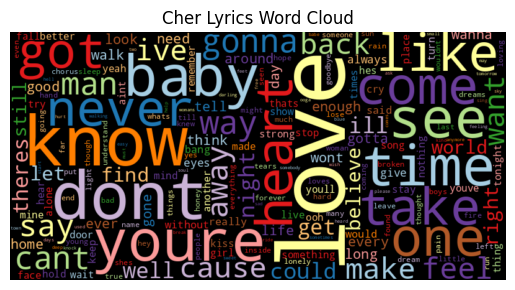

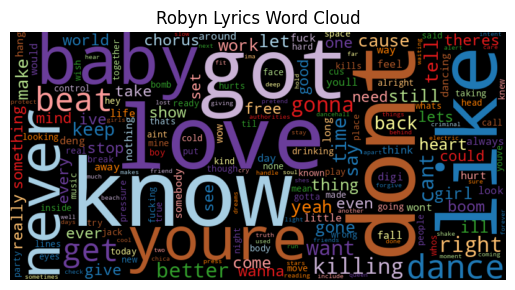

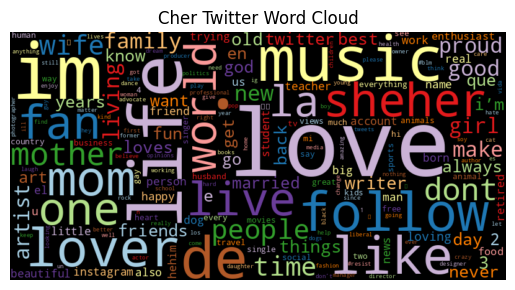

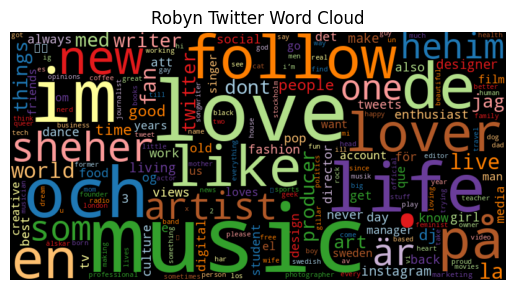

In [24]:
# Create a word cloud for Cher Lyrics
wordcloud(cher_lyrics_freq['freq'], title='Cher Lyrics Word Cloud')
plt.show()

# Create a word cloud for Robyn Lyrics
wordcloud(robyn_lyrics_freq['freq'], title='Robyn Lyrics Word Cloud')
plt.show()

# Create a word cloud for Cher Twitter
wordcloud(cher_twitter_freq['freq'], title='Cher Twitter Word Cloud')
plt.show()

# Create a word cloud for Robyn Twitter
wordcloud(robyn_twitter_freq['freq'], title='Robyn Twitter Word Cloud')
plt.show()

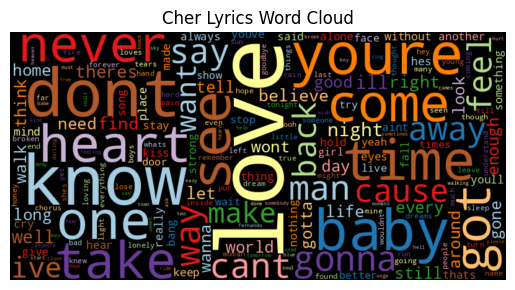

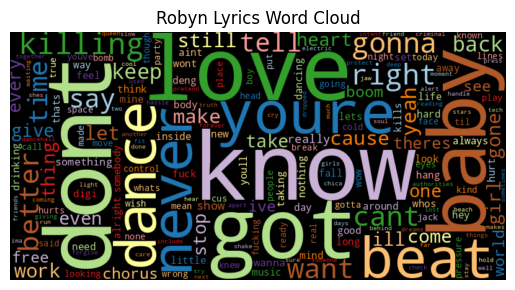

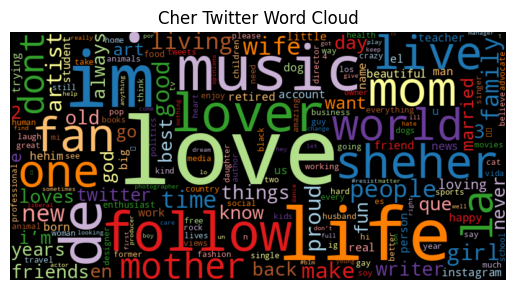

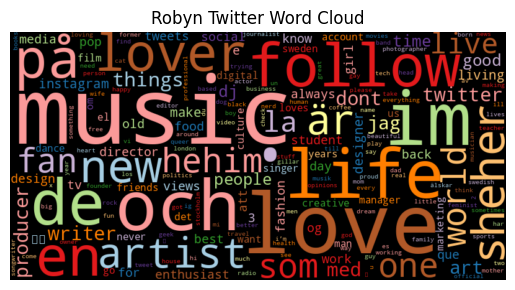

In [25]:
# Removed stopwords
stopwords = set(STOPWORDS)

# Create a word cloud for Cher Lyrics with stopwords
wordcloud(cher_lyrics_freq['freq'], title='Cher Lyrics Word Cloud',
          stopwords=stopwords)
plt.show()

# Create a word cloud for Robyn Lyrics with stopwords
wordcloud(robyn_lyrics_freq['freq'], title='Robyn Lyrics Word Cloud',
          stopwords=stopwords)
plt.show()

# Create a word cloud for Cher Twitter with stopwords
wordcloud(cher_twitter_freq['freq'], title='Cher Twitter Word Cloud',
          stopwords=stopwords)
plt.show()

# Create a word cloud for Robyn Twitter with stopwords
wordcloud(robyn_twitter_freq['freq'], title='Robyn Twitter Word Cloud',
          stopwords=stopwords)
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds?

A: It's difficult to provide a quantitative observation only that few words like "know", "baby", "don't" are prevelent between Cher and Robyn's lyrics. "Follow", "life", "live" are common between the twitter comments. And the word "love" is pretty prevelent across the 4 corpora.